In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import seaborn as sns

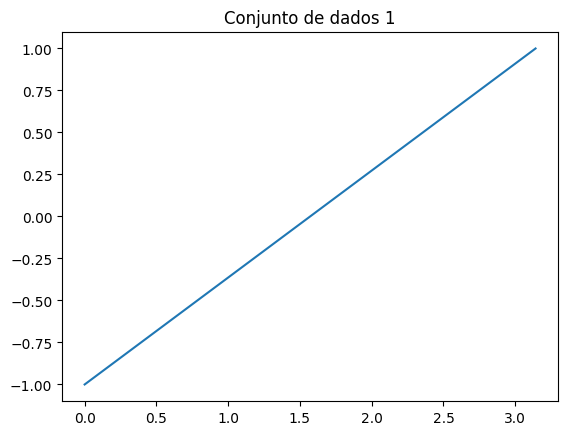

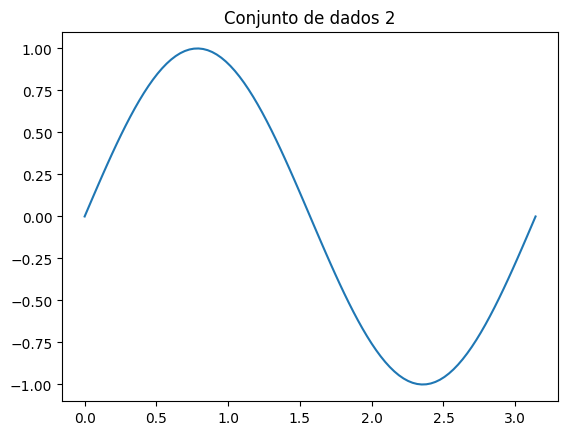

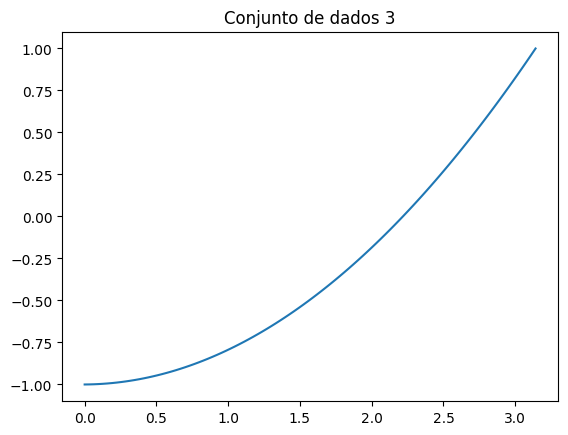

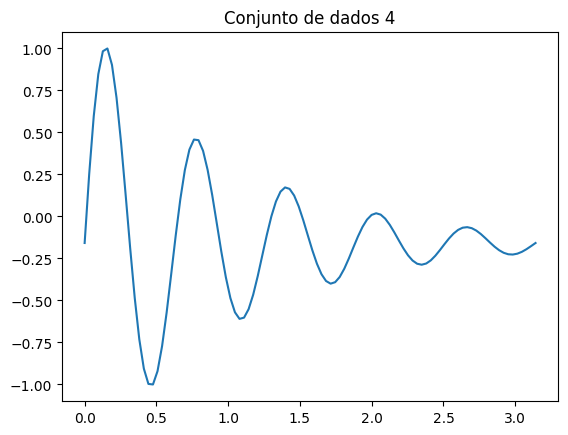

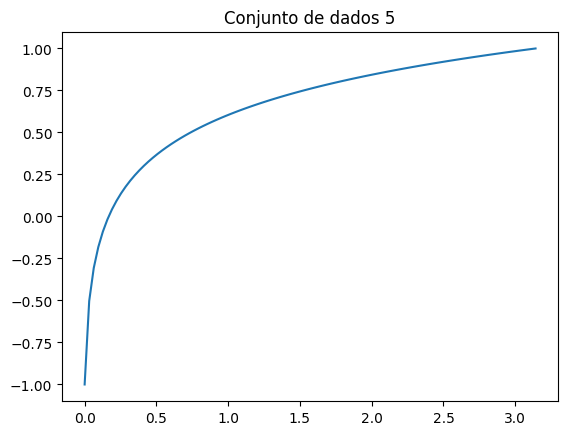

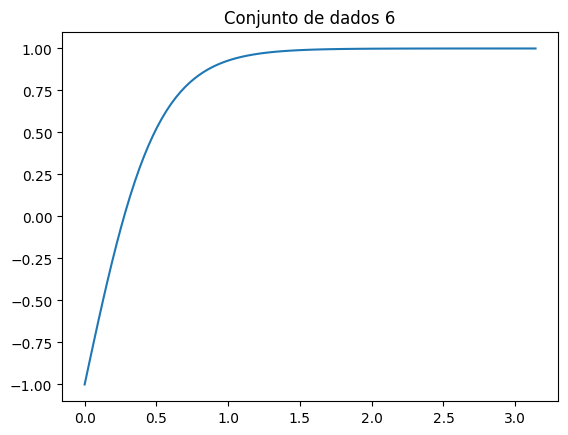

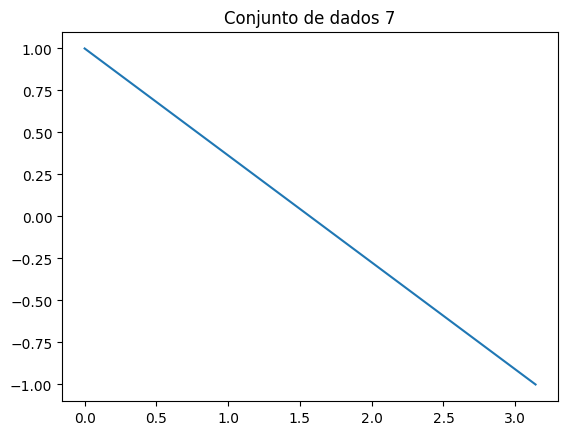

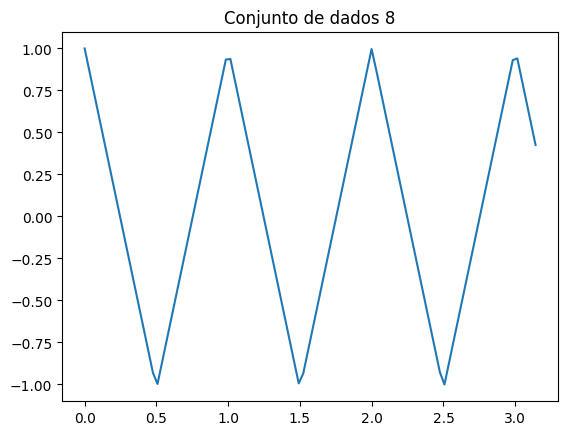

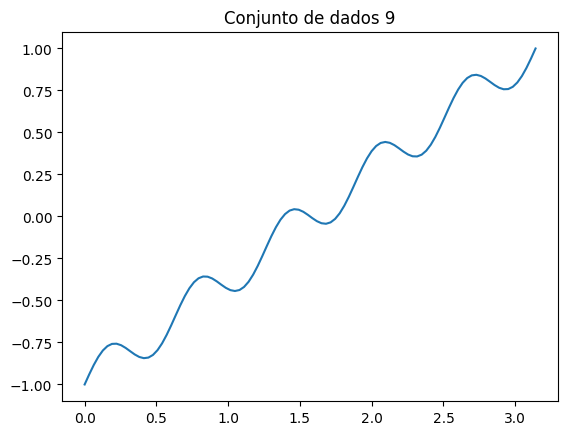

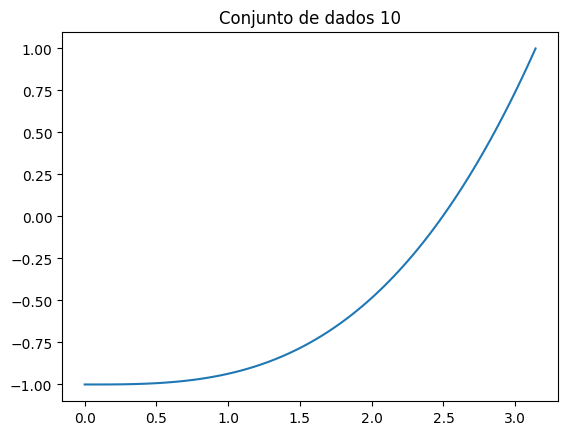

In [2]:
funcs = {
    0: lambda x: 2 * x + 1, # Linearidade simples
    1: lambda x: np.sin(x / 50), # Periodicidade
    2: lambda x: x**2 + 3 * x + 2, # Não linear com tendência crescente
    3: lambda x: np.exp(-x / 100) * np.sin(x / 10),  # damped sine wave
    4: lambda x: np.log1p(np.abs(x)),               # log-based growth
    5: lambda x: np.tanh(x / 50),                   # sigmoid-like nonlinearity
    6: lambda x: np.piecewise(x, [x < 0, x >= 0], [lambda x: x**2, lambda x: -x]),  # piecewise
    7: lambda x: np.abs(x % 100 - 50),              # triangular wave
    8: lambda x: 10 * np.sin(x / 10) + 0.5 * x,     # trend + periodicity
    9: lambda x: (x / 10)**3 - (x / 10),            # cubic polynomial
}

def min_max_norm(dataset):
    norm_dataset = {}
    X = dataset["x"] 
    Y = dataset["y"] 

    norm_dataset["x"] = ((X - np.min(X)) / (np.max(X) - np.min(X))) *np.pi
    norm_dataset["y"] = (Y - np.min(Y)) / (np.max(Y) - np.min(Y)) *2 -1

    return norm_dataset

def generate_dataset(func, x_min=0, x_max=100 * np.pi, num_samples=100):

    X = np.linspace(x_min, x_max, num_samples)
    y = func(X)
    return X, y

datasets = {}

for i in funcs:
    x, y = generate_dataset(funcs[i])
    datasets[i] = {}
    datasets[i]["x"] = x
    datasets[i]["y"] = y

    datasets[i] = min_max_norm(datasets[i])

for i in datasets:
    plt.title(f"Conjunto de dados {i+1}")
    plt.plot(datasets[i]['x'], datasets[i]['y'])
    plt.show()

In [3]:
class QuantumRegressor(object):
    def __init__(self, n_qubits=1, n_layers=3):
        """
        Initialize the QuantumRegressor.

        Inputs:
            n_qubits (int): Number of qubits to use in the quantum circuit.
            n_layers (int): Number of layers in the quantum circuit.

        Outputs:
            None
        """
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.device = qml.device('lightning.qubit', wires=self.n_qubits)
        self.training_time = None
        self.circuit_depth = self._calculate_circuit_depth()
        self.training_time = -1

        if self.n_qubits > 1:
            shape = qml.StronglyEntanglingLayers.shape(n_layers=self.n_layers, n_wires=self.n_qubits)
            self.parameters = 0.01 * np.random.randn(*shape, requires_grad=True)
        else:
            self.parameters = 0.01 * np.random.randn(self.n_layers, 3, requires_grad=True)

        self.bias = np.array(0.0, requires_grad=True)

        @qml.qnode(self.device)
        def quantum_circuit(params, x_input):
            """
            Quantum circuit for regression.

            Inputs:
                params (np.ndarray): Parameters for the quantum gates.
                x_input (np.ndarray): Input features, should have length equal to n_qubits.

            Outputs:
                float: Expectation value of PauliZ on wire 0.
            """
            if len(x_input) != self.n_qubits:
                raise ValueError(f"Input must have exactly {self.n_qubits} features, got {len(x_input)}")
            
            # Embedding!
            
            features = np.array(x_input)
            qml.AngleEmbedding(features=features, wires=range(self.n_qubits), rotation='Y')
            
            
            if self.n_qubits > 1:
                qml.StronglyEntanglingLayers(weights=params, wires=range(self.n_qubits))
            else:
                for i in range(self.n_layers):
                    qml.Rot(*params[i], wires=0)
            return qml.expval(qml.PauliZ(0))
        self.qnode = quantum_circuit

    def _calculate_circuit_depth(self):
        """
        Calculate the depth of the quantum circuit.

        Inputs:
            None

        Outputs:
            int: The depth of the quantum circuit.
        """
        embedding_depth = 1
        if self.n_qubits > 1:
            processing_depth = self.n_layers * 2
        else:
            processing_depth = self.n_layers
        return embedding_depth + processing_depth

    @staticmethod
    def loss_fn(y_true, y_pred):
        """
        Compute the mean absolute error loss.

        Inputs:
            y_true (np.ndarray): True target values.
            y_pred (np.ndarray or list): Predicted values.

        Outputs:
            float: Mean absolute error between y_true and y_pred.
        """
        return np.mean(np.abs(y_true - y_pred))

    def compute_loss(self, X, y, params=None, bias=None):
        """
        Compute the loss for a given dataset and parameters.

        Inputs:
            X (np.ndarray): Input features, shape (num_samples, num_features).
            y (np.ndarray): Target values.
            params (np.ndarray, optional): Parameters for the quantum circuit. If None, uses self.parameters.
            bias (np.ndarray, optional): Bias term. If None, uses self.bias.

        Outputs:
            float: Computed loss value.
        """
        if params is None:
            params = self.parameters
        if bias is None:
            bias = self.bias
        if X.shape[1] != self.n_qubits:
            raise ValueError(f"Input features must have {self.n_qubits} columns, got {X.shape[1]}")
        y_pred = np.array([self.qnode(params, x) + bias for x in X])
        return self.loss_fn(y, y_pred)

    def forward(self, x_input, params=None, bias=None):
        """
        Perform a forward pass through the quantum circuit.

        Inputs:
            x_input (np.ndarray): Input features, length should be n_qubits.
            params (np.ndarray, optional): Parameters for the quantum circuit. If None, uses self.parameters.
            bias (np.ndarray, optional): Bias term. If None, uses self.bias.

        Outputs:
            float: Predicted value for the input.
        """
        if params is None:
            params = self.parameters
        if bias is None:
            bias = self.bias
        if len(x_input) != self.n_qubits:
            raise ValueError(f"Input must have exactly {self.n_qubits} features, got {len(x_input)}")
        return self.qnode(params, x_input) + bias

    def predict_single(self, x_input):
        """
        Predict the output for a single input value.

        Inputs:
            x_input (np.ndarray): Input features, length should be n_qubits.

        Outputs:
            float: Predicted value for the input.
        """
        return self.forward(x_input)

    def plot_circuit(self, expand_layers=True):
        """
        Plot the quantum circuit using matplotlib.

        Inputs:
            expand_layers (bool): If True, expands the StronglyEntanglingLayers to show individual gates.
                                  If False, shows the compact representation.

        Outputs:
            None
        """
        features = np.ones(self.n_qubits)
        if expand_layers:
            @qml.qnode(self.device)
            def expanded_circuit(params, x_input):
                features = np.array(x_input)
                qml.AngleEmbedding(features=features, wires=range(self.n_qubits), rotation='Z')
                if self.n_qubits > 1:
                    for layer in range(self.n_layers):
                        for wire in range(self.n_qubits):
                            qml.Rot(*params[layer, wire, :3], wires=wire)
                        for wire in range(self.n_qubits - 1):
                            qml.CNOT(wires=[wire, wire + 1])
                        if self.n_qubits > 2:
                            qml.CNOT(wires=[self.n_qubits - 1, 0])
                else:
                    for i in range(self.n_layers):
                        qml.Rot(*params[i], wires=0)
                return qml.expval(qml.PauliZ(0))
            fig, ax = qml.draw_mpl(expanded_circuit)(self.parameters, features)
        else:
            fig, ax = qml.draw_mpl(self.qnode)(self.parameters, features)
        plt.show()

    def predict(self, X):
        """
        Predict outputs for multiple input samples.

        Inputs:
            X (np.ndarray): Input features, shape (num_samples, num_features).

        Outputs:
            list: List of predicted values for each input sample.
        """
        if X.shape[1] != self.n_qubits:
            raise ValueError(f"Input features must have {self.n_qubits} columns, got {X.shape[1]}")
        return [self.forward(x) for x in X]

    def batch_loss(self, params, bias, X_batch, y_batch):
        """
        Compute the loss for a batch of data.

        Inputs:
            params (np.ndarray): Parameters for the quantum circuit.
            bias (np.ndarray): Bias term.
            X_batch (np.ndarray): Batch of input features.
            y_batch (np.ndarray): Batch of target values.

        Outputs:
            float: Computed loss value for the batch.
        """
        return self.compute_loss(X_batch, y_batch, params, bias)

    def fit(self, X, y, epochs=100, batch_size=10, learning_rate=0.01):
        """
        Train the model on data (X, y) using NesterovMomentumOptimizer.

        Inputs:
            X (np.ndarray): Input features, shape (num_samples, num_features).
            y (np.ndarray): Target values.
            epochs (int): Number of training epochs.
            batch_size (int): Size of each training batch.
            learning_rate (float): Learning rate for the optimizer.

        Outputs:
            None
        """
        if X.shape[1] != self.n_qubits:
            raise ValueError(f"Input features must have {self.n_qubits} columns, got {X.shape[1]}")
        optimizer = NesterovMomentumOptimizer(learning_rate)
        params = self.parameters
        bias = self.bias
        n_samples = X.shape[0]
        best_params = params.copy()
        best_bias = bias.copy()
        best_loss = float('inf')
        start_time = time.time()
        with tqdm(range(epochs), desc=f"Model ({self.n_qubits}×{self.n_layers}) Training") as pbar:
            for epoch in pbar:
                actual_batch_size = min(batch_size, n_samples)
                batch_indices = np.random.choice(n_samples, actual_batch_size, replace=False)
                X_batch = X[batch_indices, :]
                y_batch = y[batch_indices]
                params, bias, _, _ = optimizer.step(
                    self.batch_loss, params, bias, X_batch, y_batch
                )
                loss = self.compute_loss(X, y, params, bias)
                pbar.set_postfix({"loss": f"{loss:.6f}"})
                if loss < best_loss:
                    best_loss = loss
                    best_params = params.copy()
                    best_bias = bias.copy()
        end_time = time.time()
        self.training_time = end_time - start_time
        self.parameters = best_params
        self.bias = best_bias

    def stats(self, y_pred, y_true, verbose=True):
        """
        Calculate and display statistics for the quantum regressor.

        Inputs:
            y_pred (array-like): Predicted values from the model.
            y_true (array-like): True/actual target values.
            verbose (bool, optional): Whether to print results to console.

        Outputs:
            dict: Dictionary containing calculated metrics (MSE, R2 score, training time, number of qubits, circuit depth).
        """
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        results = {
            'MSE': mse,
            'R2_Score': r2,
            'Training_Time': self.training_time,
            'N_Qubits': self.n_qubits,
            'N_layers':self.n_layers,
            'Circuit_Depth': self.circuit_depth
        }
        spaces = 80
        if verbose:
            print(f"""
                    {'='*spaces}
                    QUANTUM REGRESSOR STATISTICS
                    {'='*spaces}
                    {'Metric':<25} {'Value':<20} {'Description'}
                    {'-'*spaces}
                    {'Mean Squared Error (MSE)':<25} {mse:<20.6f} {'Mean squared error of prediction'}
                    {'R² Score':<25} {r2:<20.6f} {'Coefficient of determination'}
                    {'Training Time (s)':<25} {self.training_time:<20.6f} {'Total training time'}
                    {'Number of Qubits':<25} {self.n_qubits:<20} {'Required resources'}
                    {'Number of Layers':<25} {self.n_layers:<20} {'Required resources'}
                    {'Circuit Depth':<25} {self.circuit_depth:<20} {'Generated circuit complexity'}
                    {'='*spaces}
                    """)
        return results


In [4]:
def get_data_for_qubits(n_qubits, dataset):
    """
    Returns the input data X in shape (m, n_qubits), where m is the number of data points
    and n_qubits is the number of qubits (features).

    Inputs:
        n_qubits (int): Number of qubits (features) to repeat the input data for.
        dataset (dict): The dataset containing the "x" key for input data.

    Outputs:
        X (np.ndarray): Input data array of shape (m, n_qubits), where m is the number of data points.
    """
    x = dataset["x"]
    # Repeat the x column n_qubits times to form the feature matrix
    if n_qubits <=1:
        X = x.reshape(-1, 1)
    else:
        X = np.column_stack([x for _ in range(n_qubits)])
    return X


In [6]:
result_list = []

for n in range(1,6):
    for m in range(1,6):
        for i in range(len(datasets)):
            dataset = datasets[i]
            X = get_data_for_qubits(n_qubits=m,dataset=dataset)
            y = dataset["y"]
            X_original = dataset["x"].reshape(-1, 1)
            model = QuantumRegressor(n_qubits=m,n_layers=n)
            #model.plot_circuit()
            model.fit(X=X,y=y,epochs=500)


            y_pred = model.predict(X)

            stats = model.stats(y_pred,y,verbose=False)
            stats["embedding"] = "angle-Z"
            stats["dataset"] = i

            result_list.append(stats)

            # plt.title("Conjunto de dados")
            # plt.plot(X_original, y, label="Ground Truth")
            # plt.plot(X_original, y_pred, '--', label="Prediction")
            # plt.legend() 
            # plt.show()

result_df = pd.DataFrame(result_list)
result_df.to_csv('angle-Z.csv', index=False)
result_df

Model (5×5) Training: 100%|██████████| 500/500 [10:10<00:00,  1.22s/it, loss=0.021502]


,MSE,R2_Score,Training_Time,N_Qubits,N_layers,Circuit_Depth,embedding,dataset
0,0.022570,0.933630,79.079513,1,1,2,angle-Z,0
1,0.160059,0.676729,77.507351,1,1,2,angle-Z,1
2,0.006235,0.982812,77.247370,1,1,2,angle-Z,2
3,0.219671,-0.549443,76.838109,1,1,2,angle-Z,3
4,0.031733,0.743674,77.072277,1,1,2,angle-Z,4
...,...,...,...,...,...,...,...,...
245,0.022603,0.893210,610.732187,5,5,11,angle-Z,5
246,0.000856,0.997483,611.016393,5,5,11,angle-Z,6
247,0.325257,0.079382,612.218733,5,5,11,angle-Z,7
248,0.008796,0.973521,614.470450,5,5,11,angle-Z,8


In [7]:
def matrix_view(axis1: str, axis2: str, value: str, df: pd.DataFrame,additional_text = "",precision=1):
    """
    Gera uma matriz de confusão com coloração baseada em intensidade.

    Parâmetros:
    - axis1: nome da coluna para o eixo y (ex: "real")
    - axis2: nome da coluna para o eixo x (ex: "previsto")
    - value: nome da coluna com os valores (ex: "frequência")
    - df: DataFrame contendo essas colunas
    - mode: 'higher' para intensidade proporcional ao valor alto,
            'lower' para intensidade proporcional ao valor baixo
    """

    cmap = sns.light_palette("xkcd:copper", 10)

    # Pivotar o DataFrame
    matrix = df.pivot_table(index=axis1, columns=axis2, values=value, aggfunc='mean', fill_value=0)

    # Plotar heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt=f".{precision}f", cmap=cmap, linewidths=0.5, linecolor='gray')
    plt.title(f"{axis1.replace('_',' ')}×{axis2.replace('_',' ')} - {value.replace('_',' ')} {additional_text}")
    plt.ylabel(axis1)
    plt.xlabel(axis2)
    plt.tight_layout()
    plt.show()

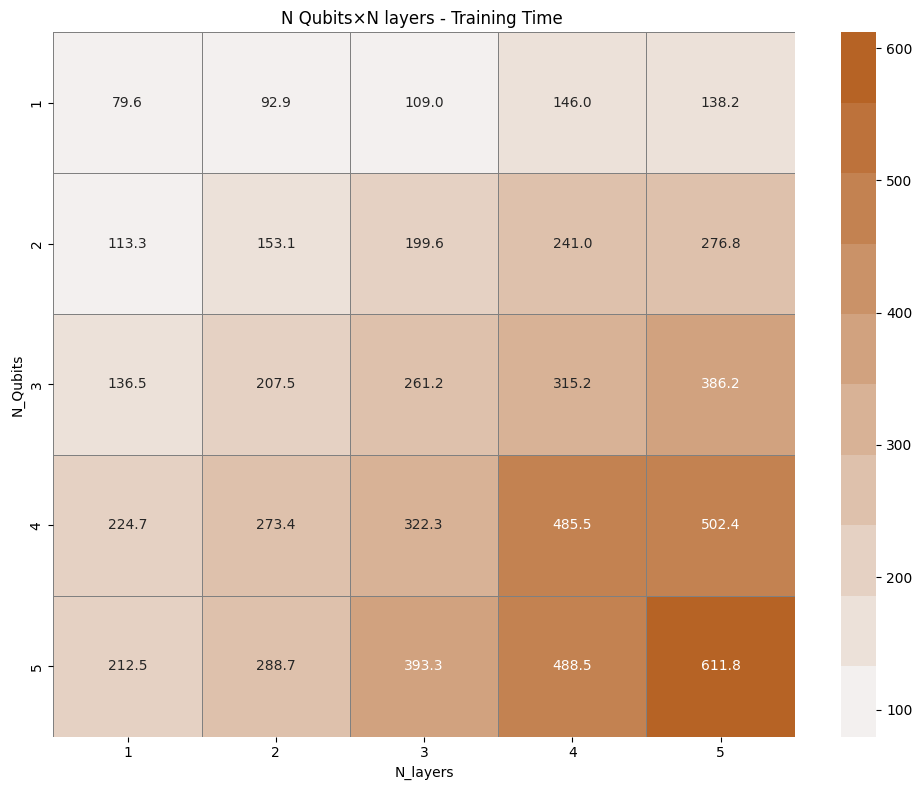

In [8]:
matrix_view("N_Qubits","N_layers","Training_Time",df =result_df )


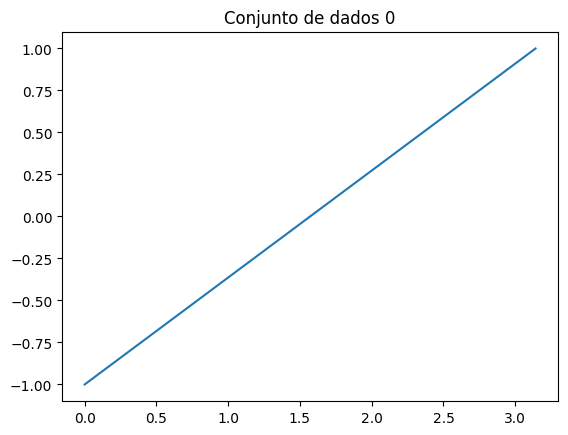

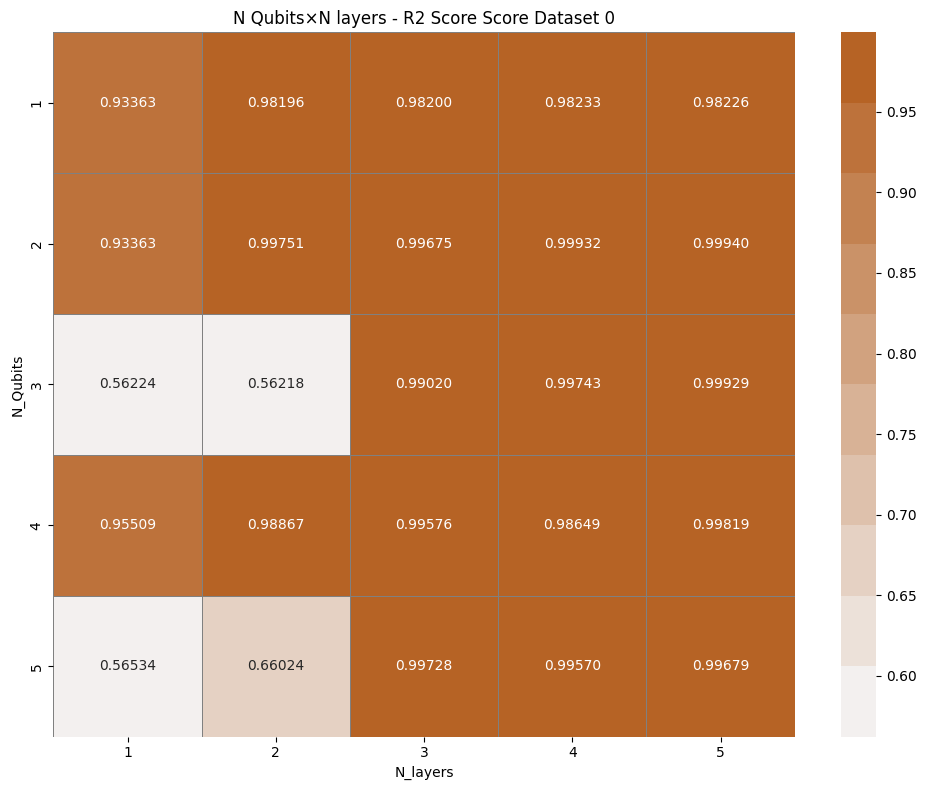

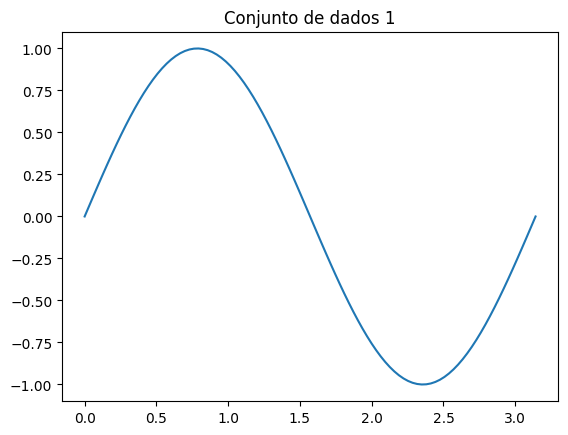

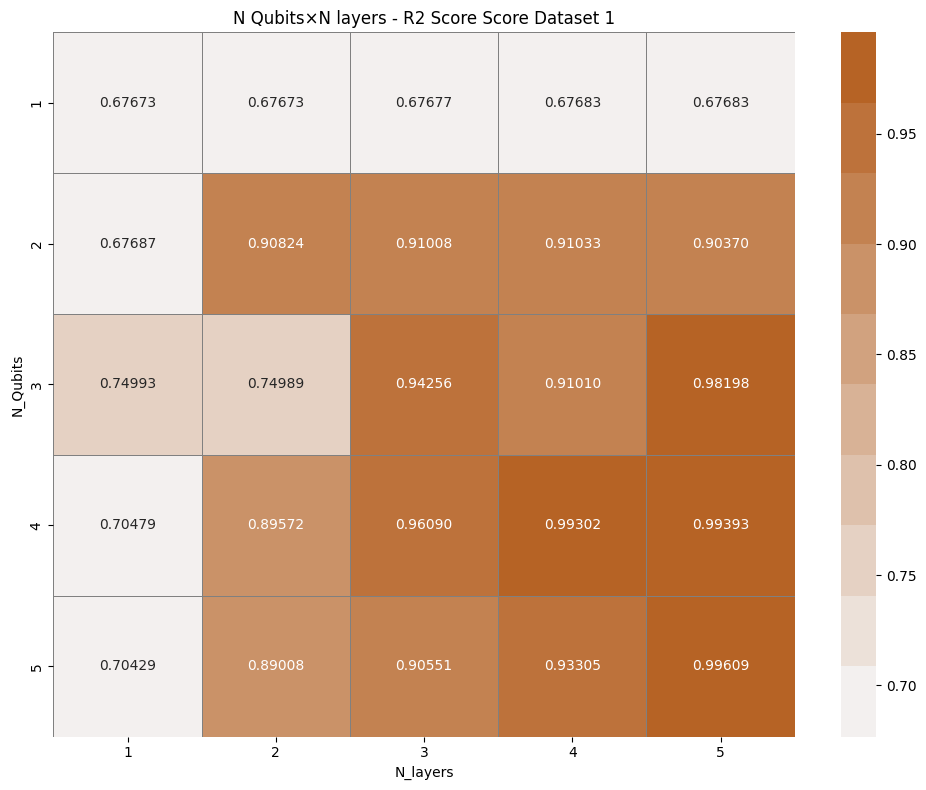

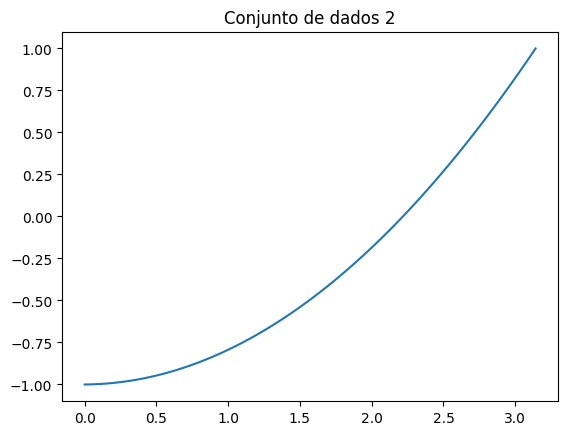

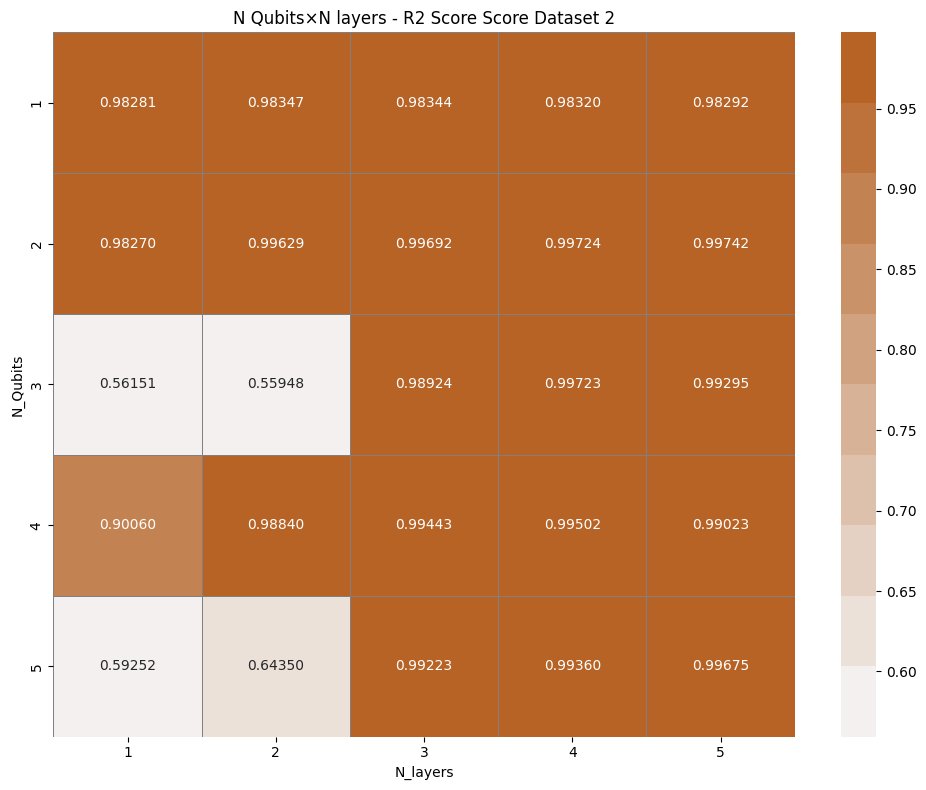

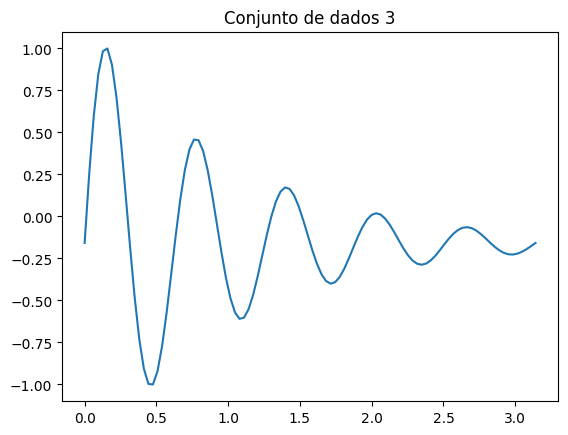

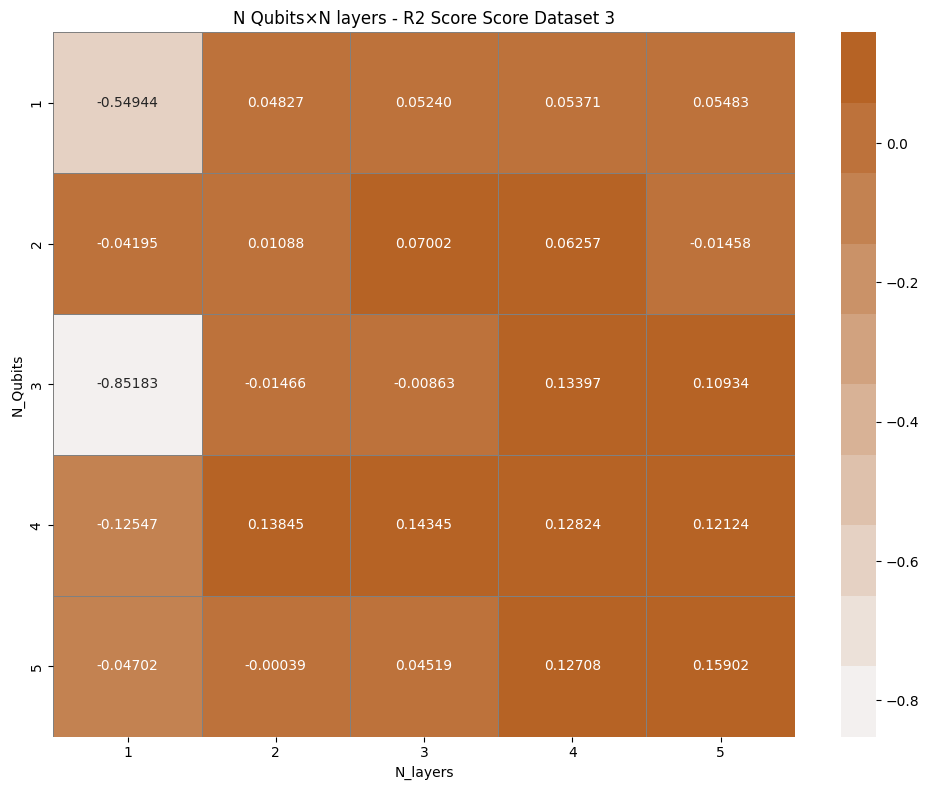

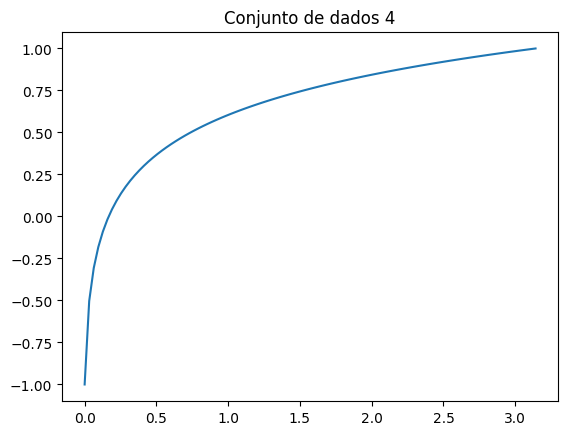

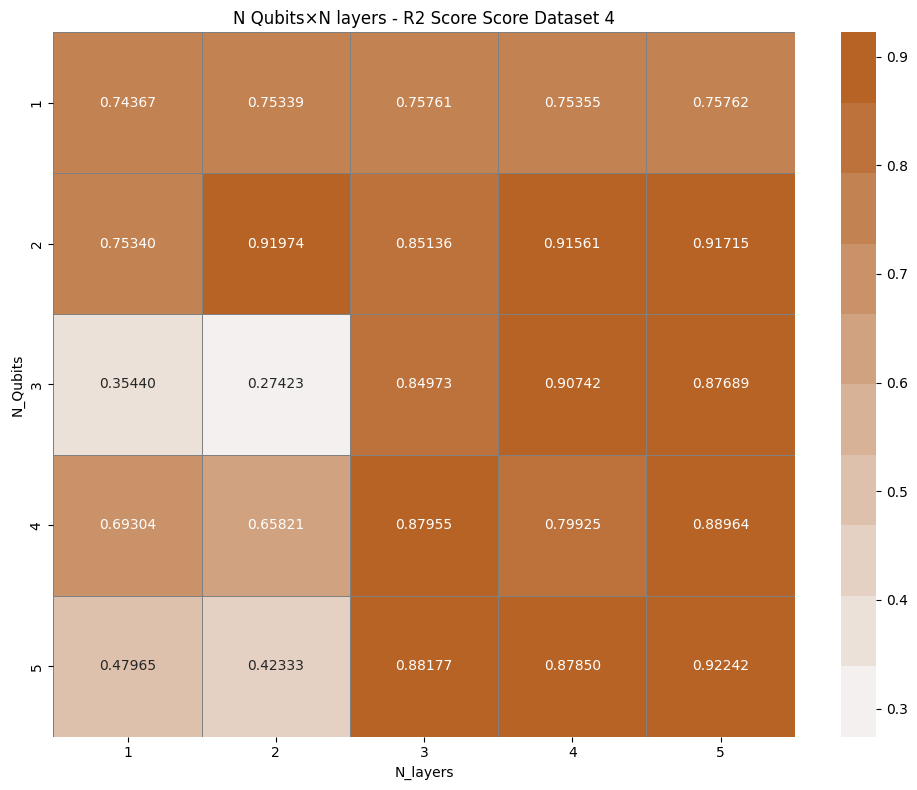

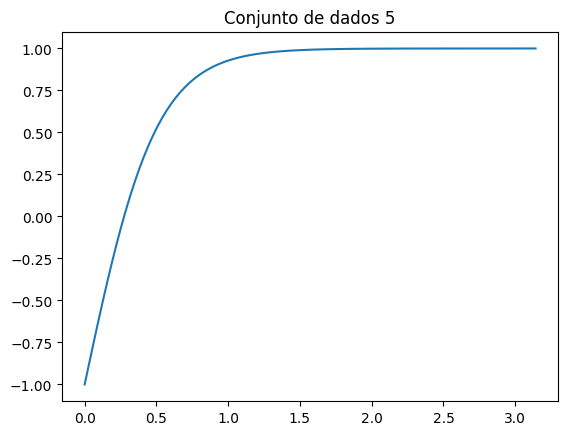

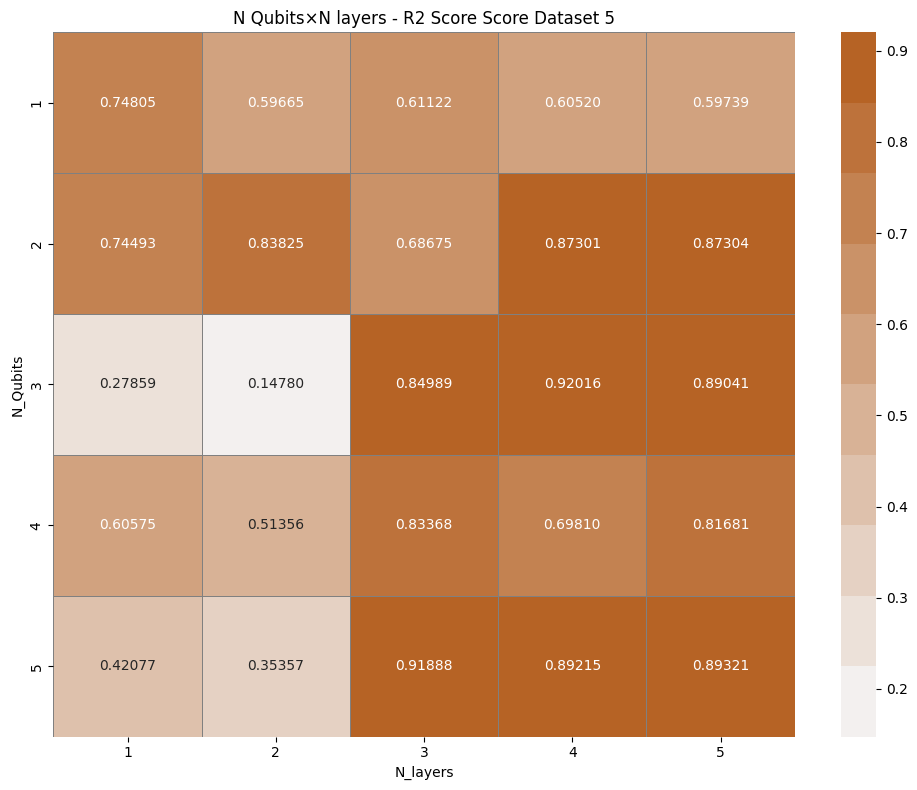

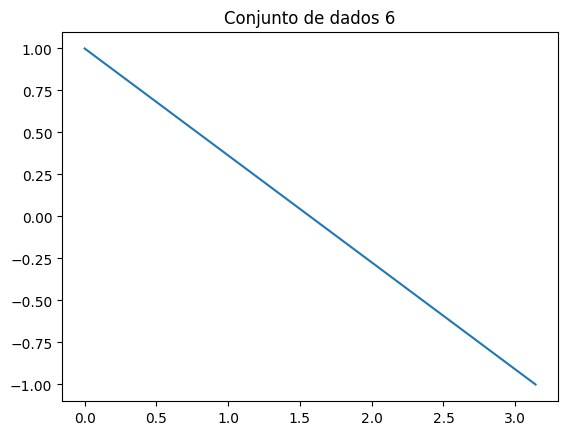

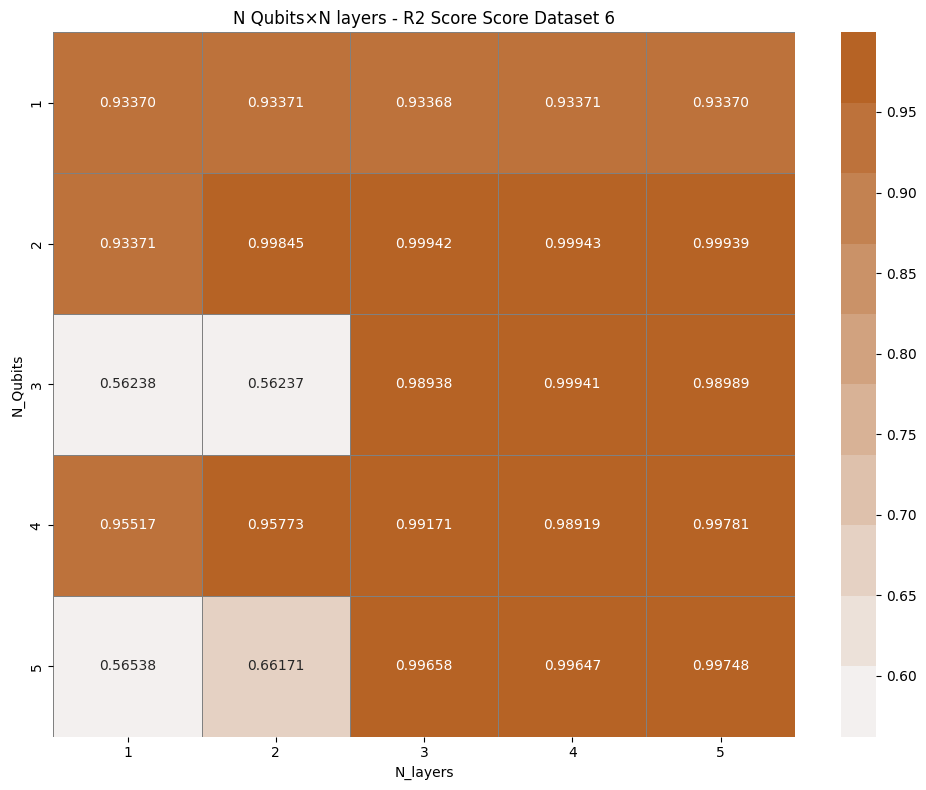

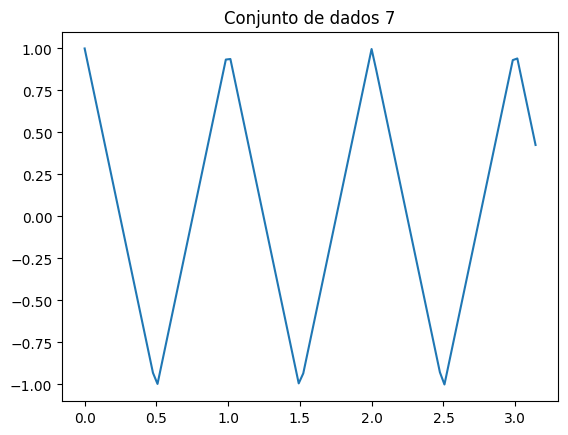

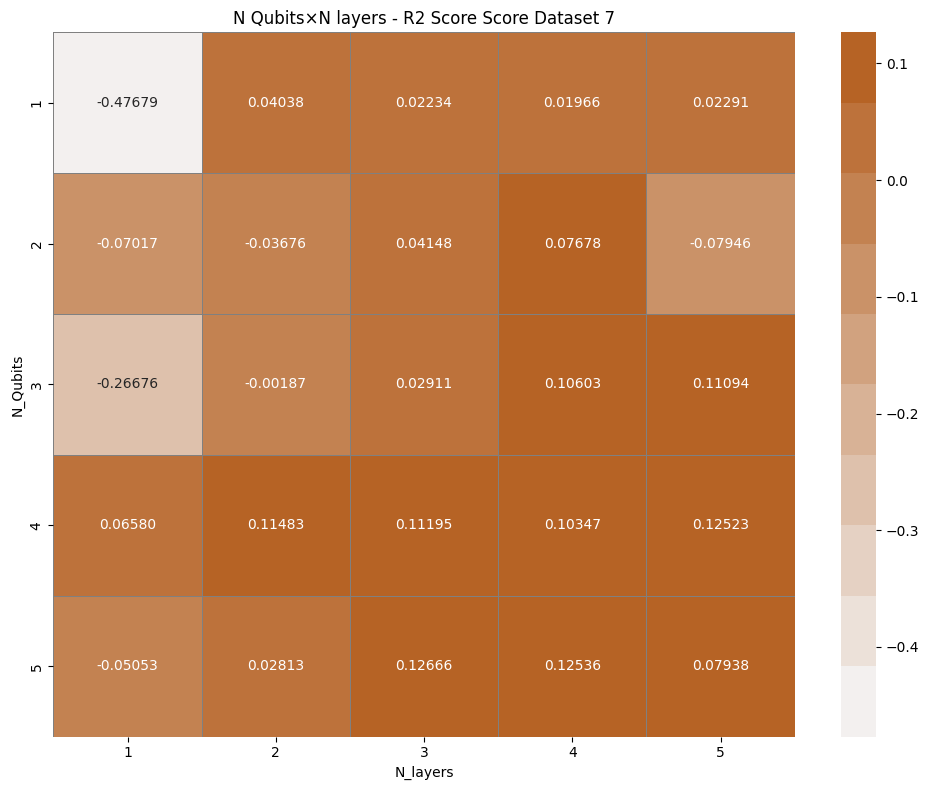

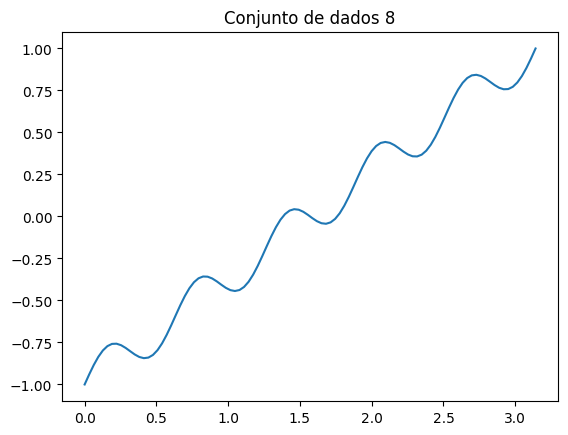

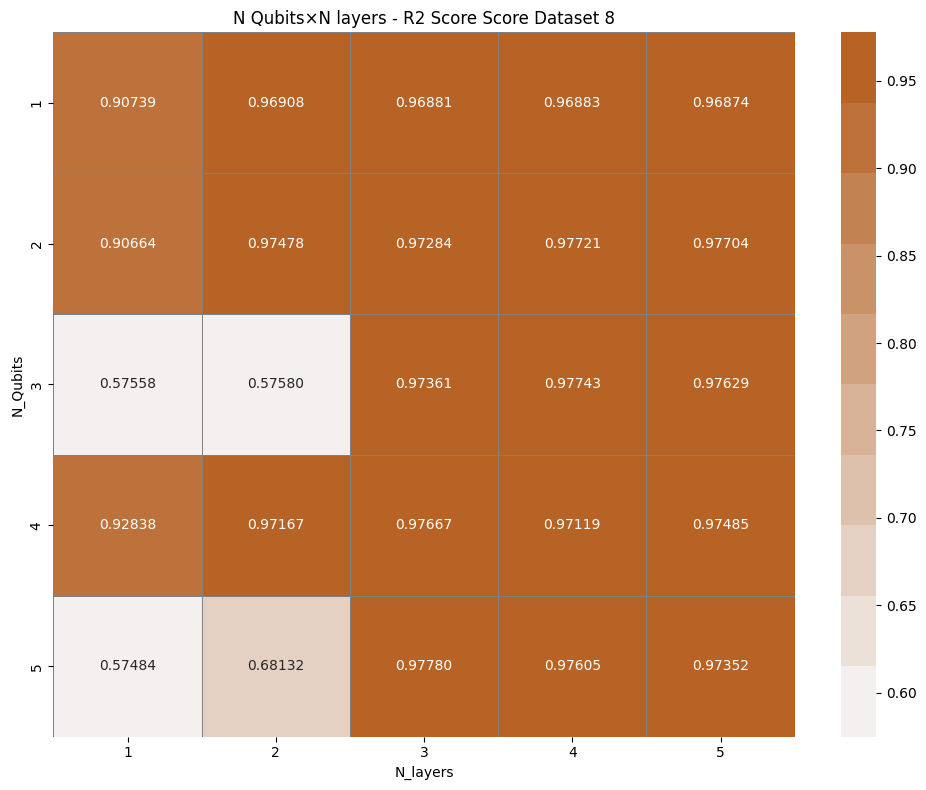

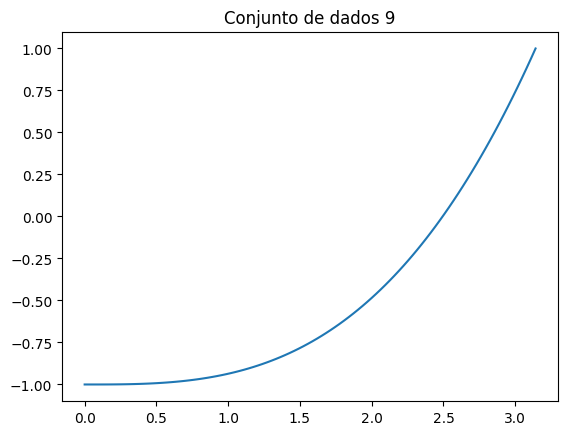

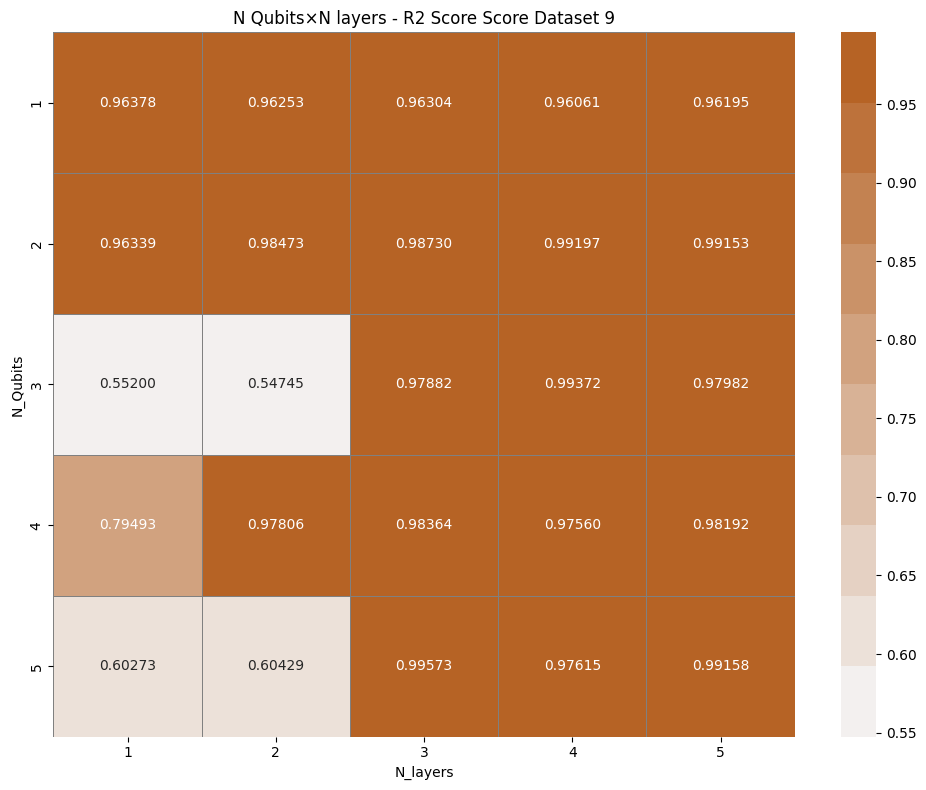

In [9]:
for i in datasets:
    plt.title(f"Conjunto de dados {i}")
    plt.plot(datasets[i]['x'], datasets[i]['y'])
    plt.show()

    view_df = result_df[result_df["dataset"]==i]
    matrix_view("N_Qubits","N_layers","R2_Score",df =view_df,additional_text=f"Score Dataset {i}",precision=5)
    plt.show()


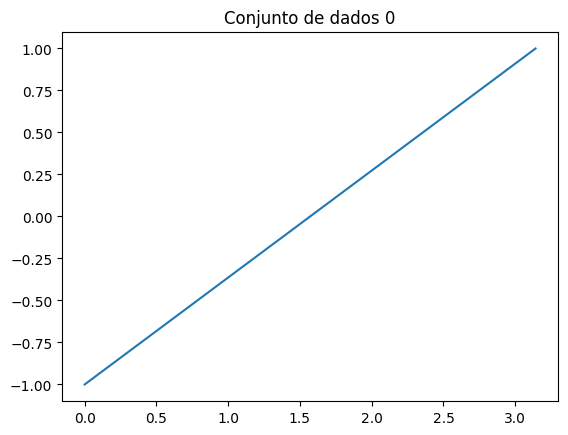

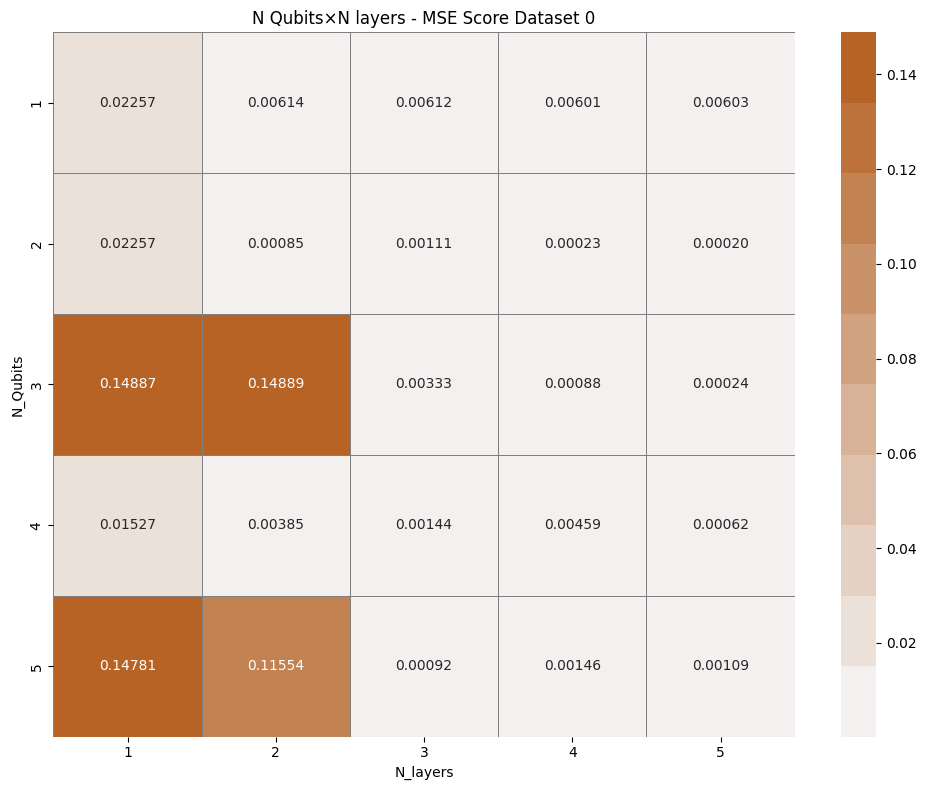

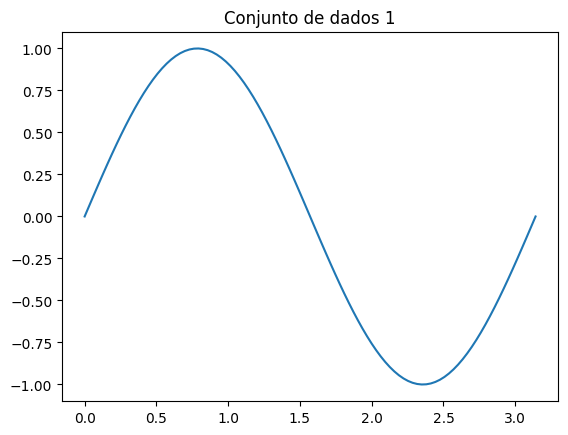

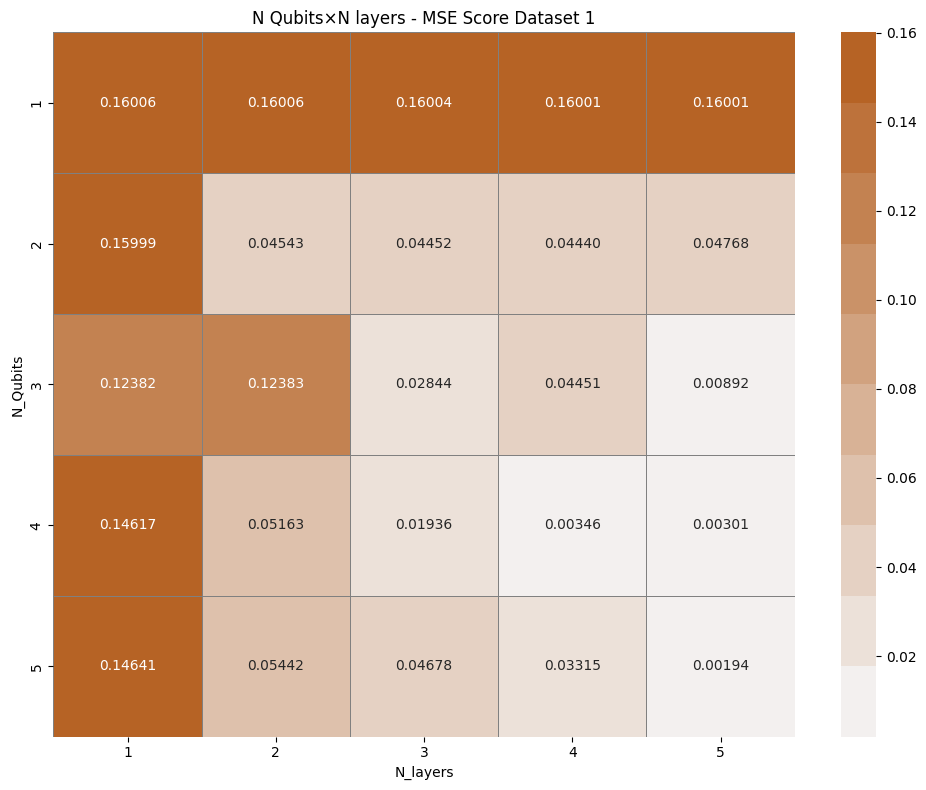

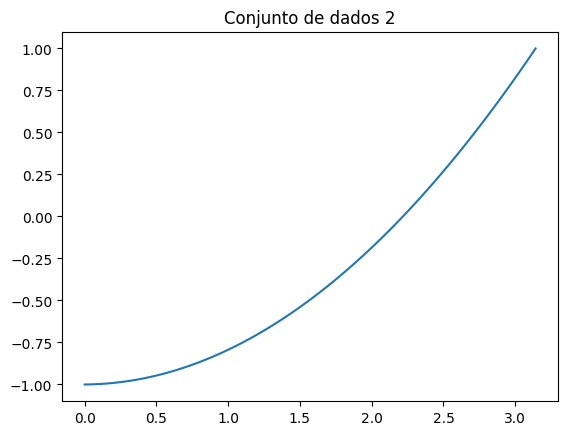

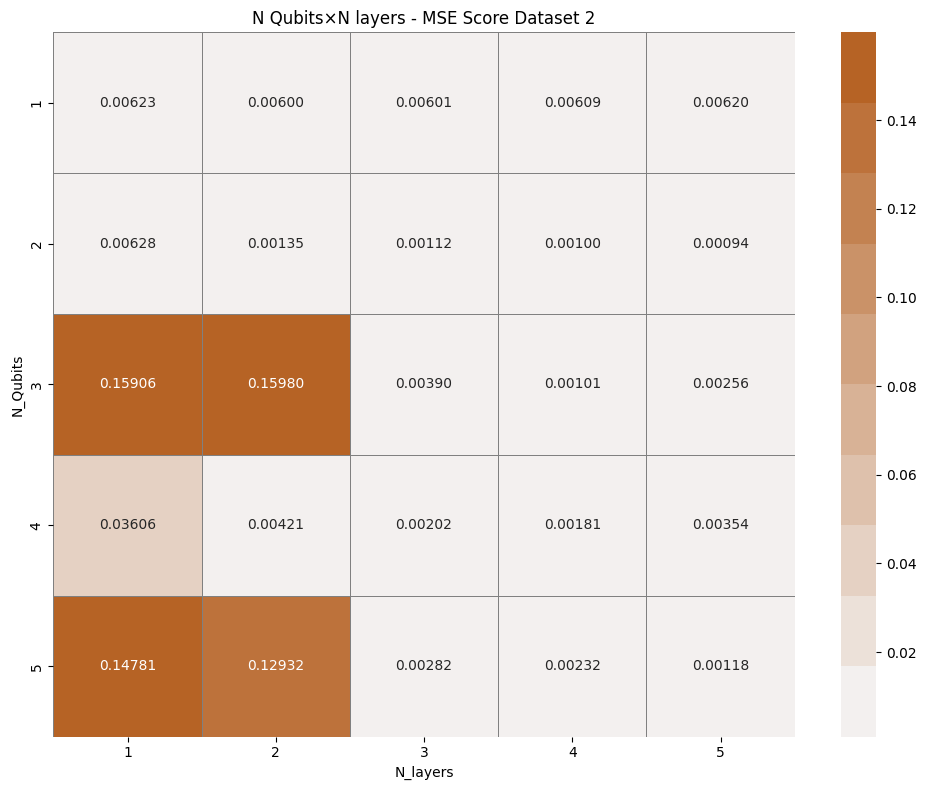

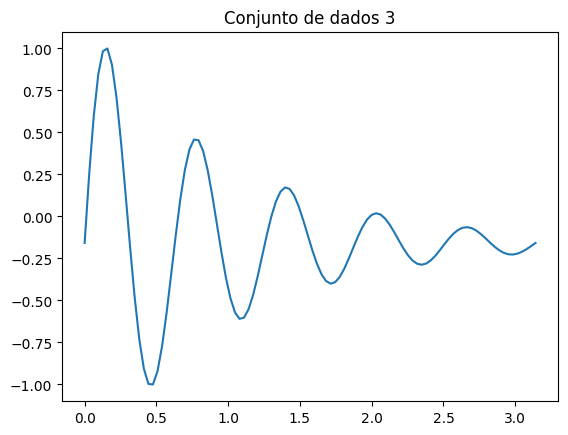

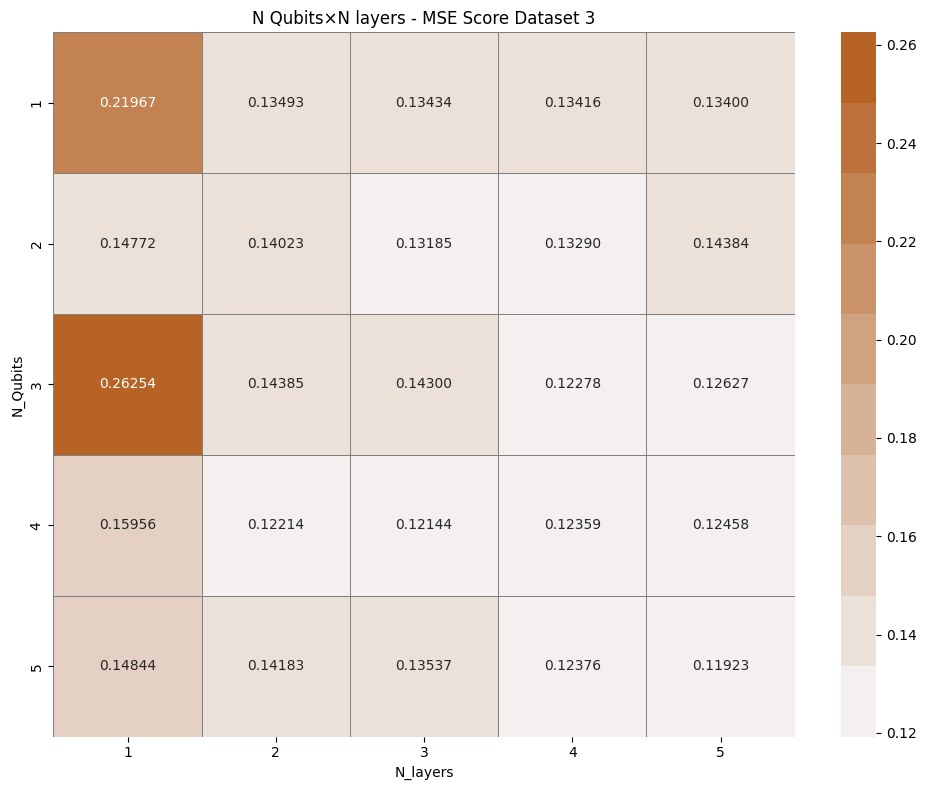

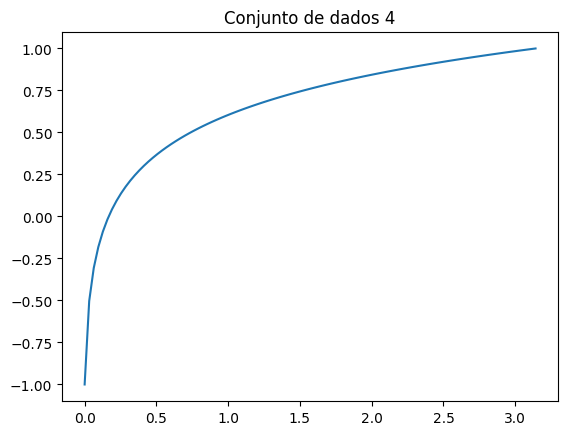

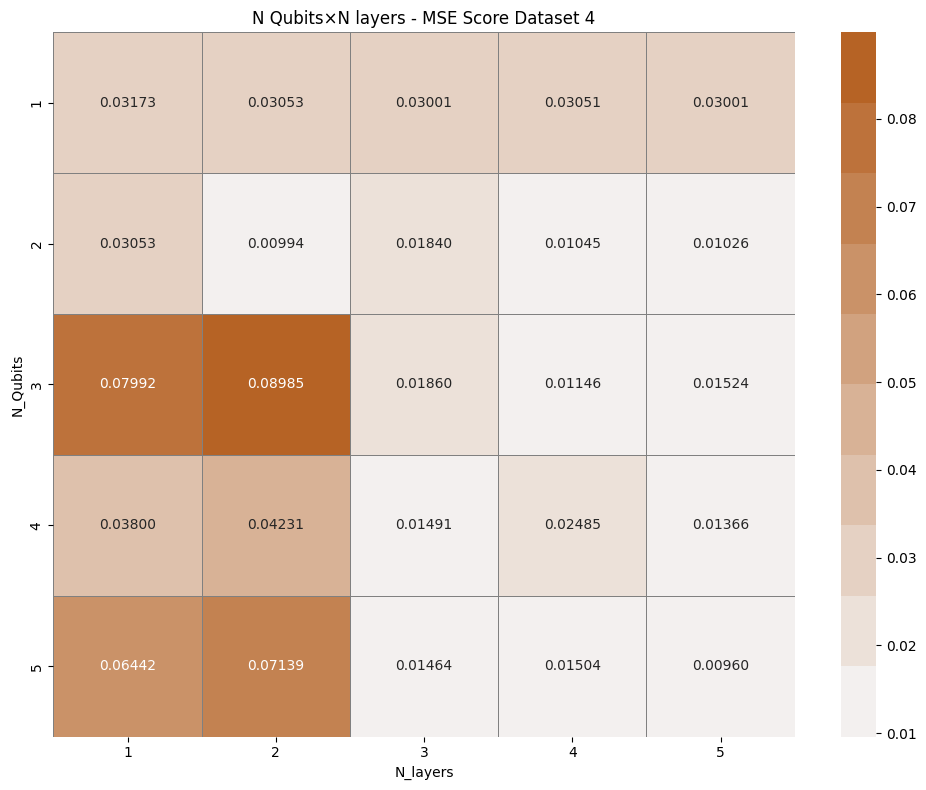

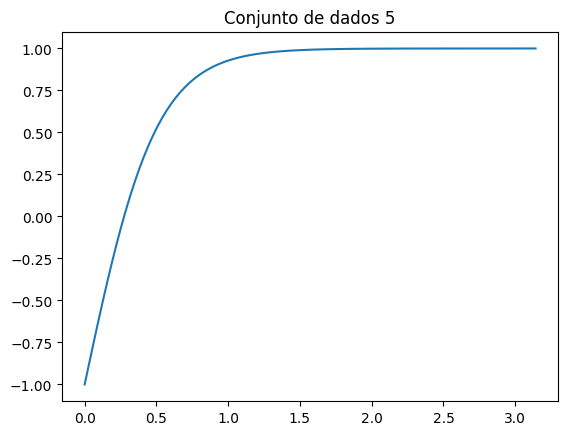

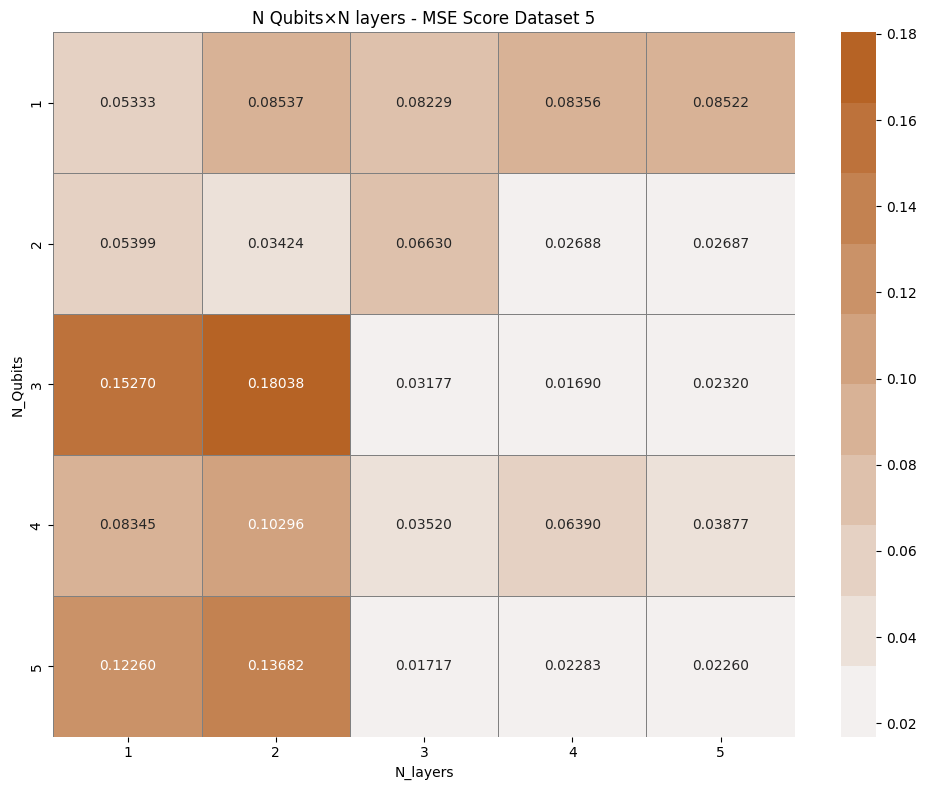

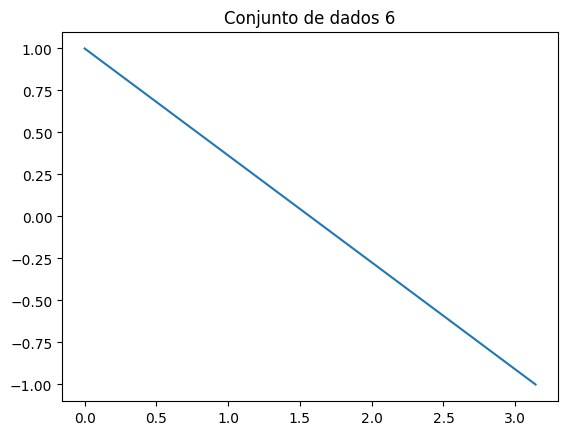

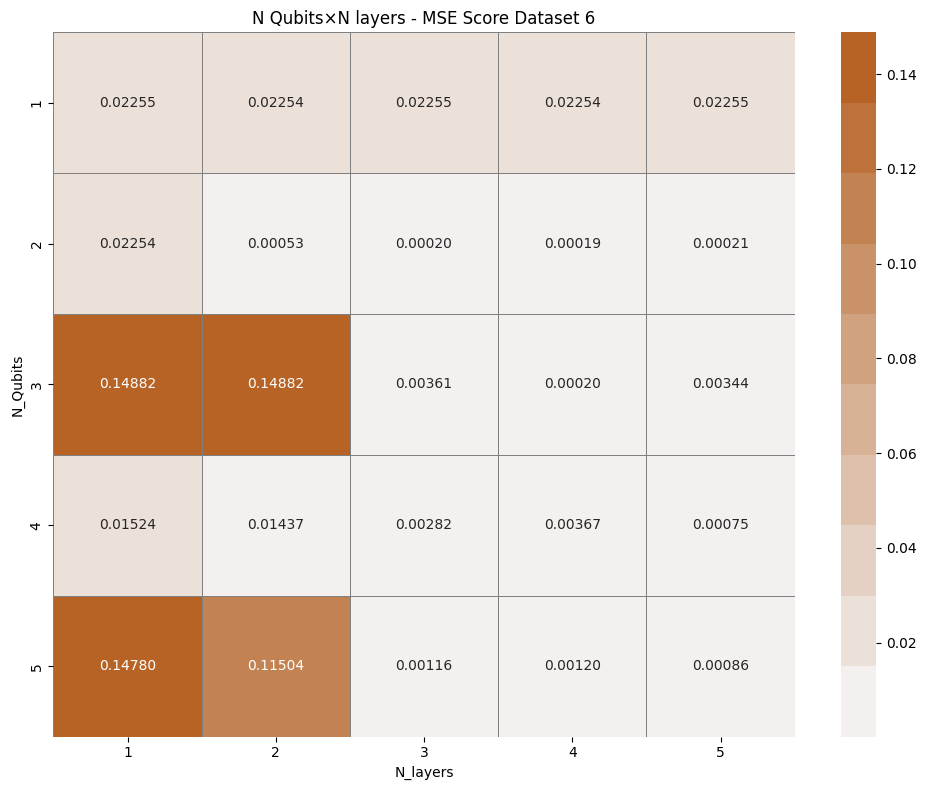

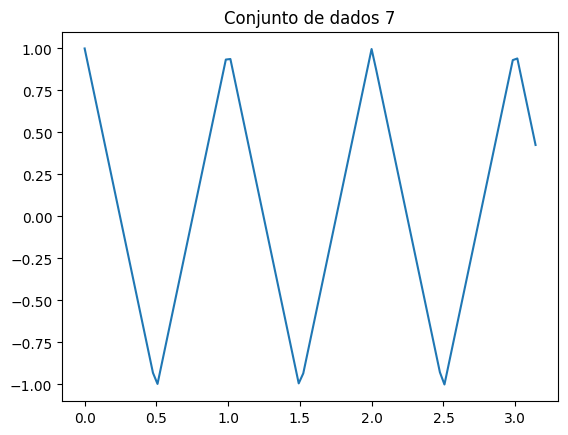

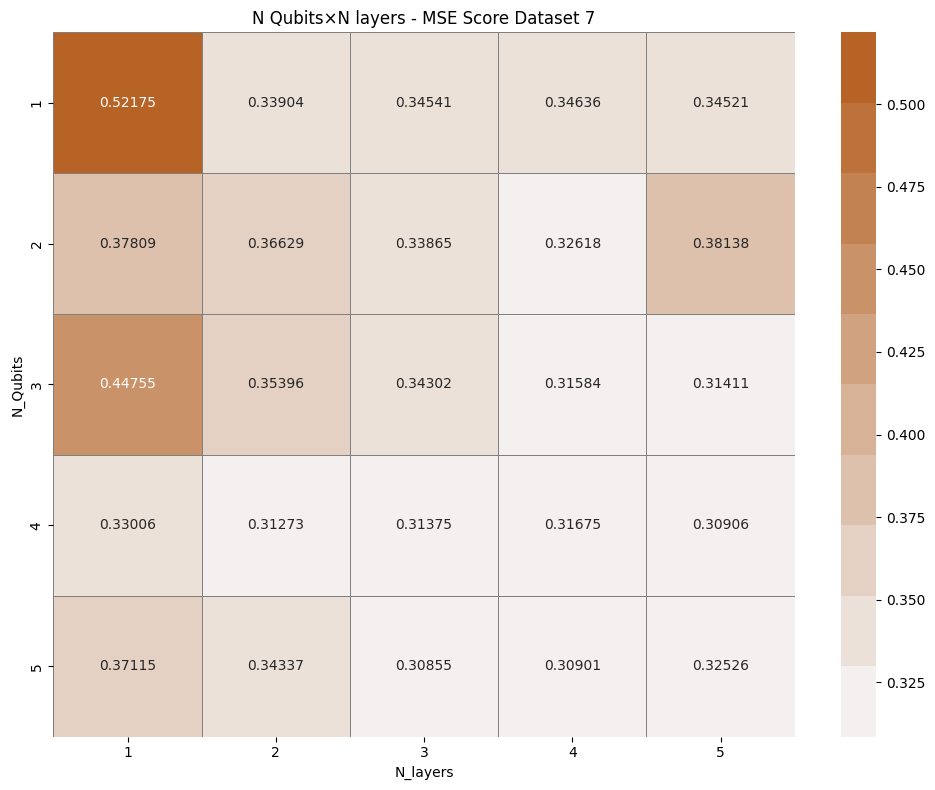

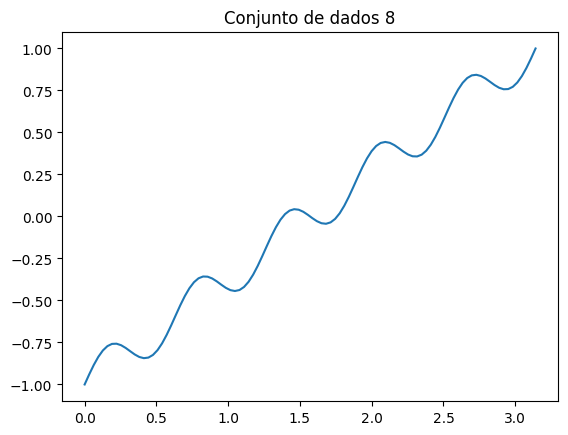

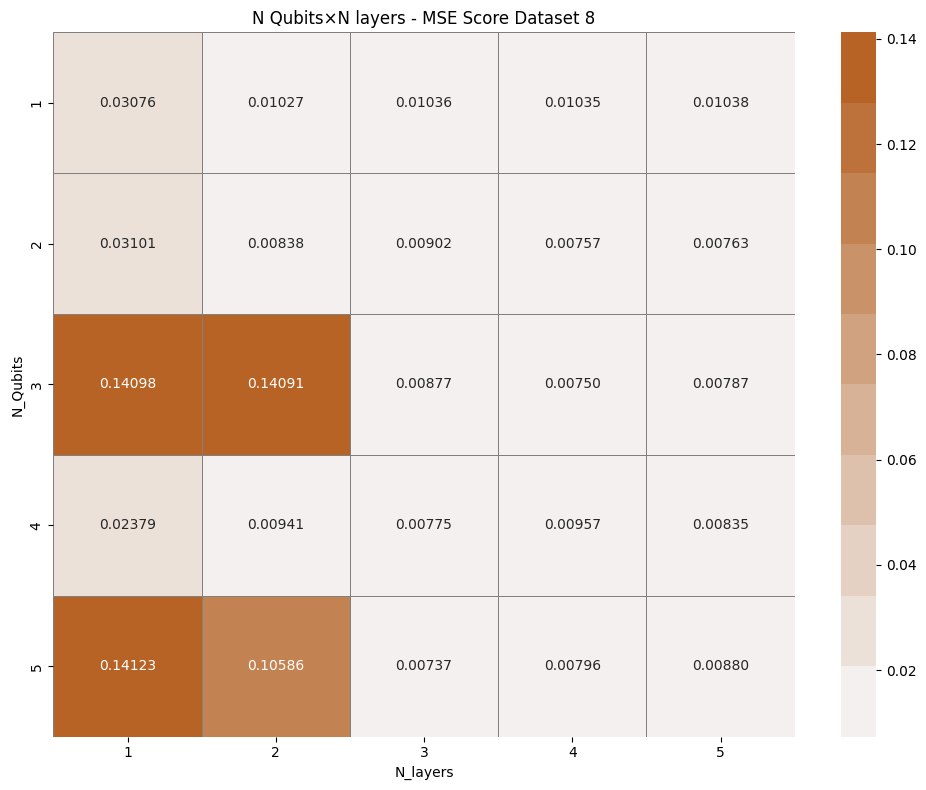

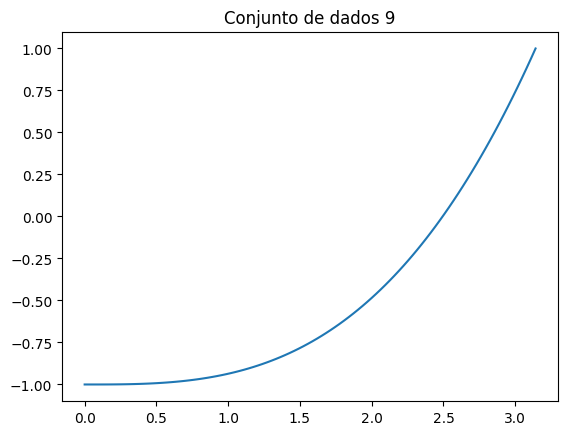

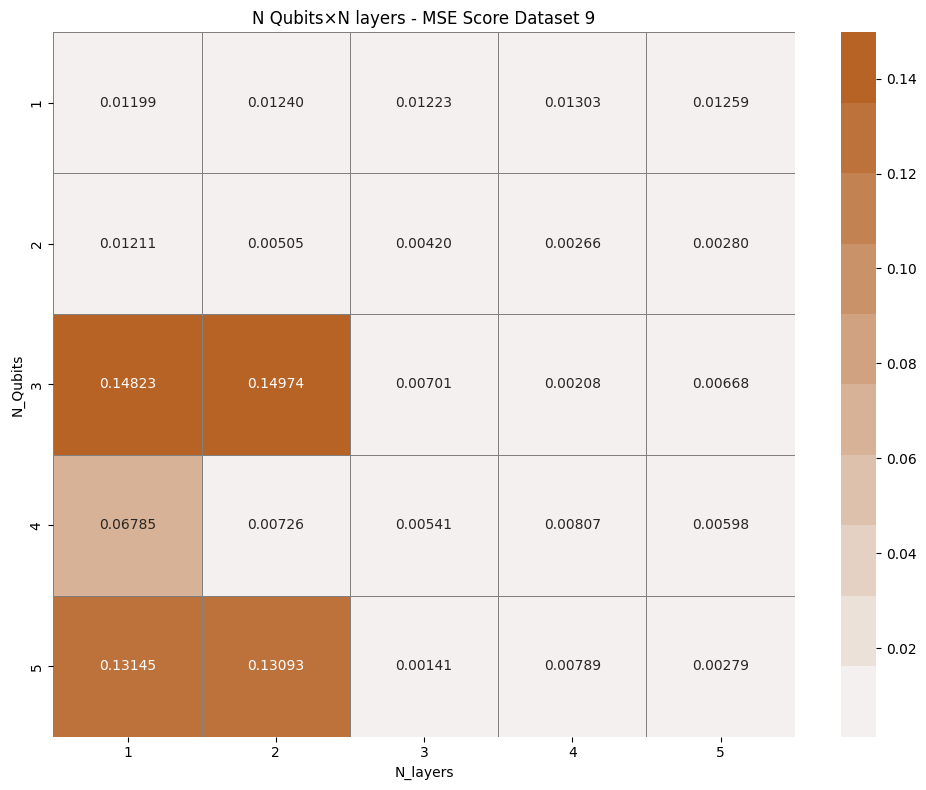

In [10]:
for i in datasets:
    plt.title(f"Conjunto de dados {i}")
    plt.plot(datasets[i]['x'], datasets[i]['y'])
    plt.show()

    view_df = result_df[result_df["dataset"]==i]
    matrix_view("N_Qubits","N_layers","MSE",df =view_df,additional_text=f"Score Dataset {i}",precision=5)
    plt.show()
